#**MAESTRÍA EN ANÁLISIS DE DATOS Y SISTEMAS INTELIGENTES**

## **APLICACIÓN DE APRENDIZAJE NO SUPERVISADO EN PROBLEMAS PRÁCTICOS**
### **MÉTODO DE AGLOMERACIÓN JERÁRQUICA - LINKAGE**


*   Edwar David Macías López
*   Miguel Andres Arias Romero
*   Javier Santiago Hernandez Mendez
*   Jhon Freddy Hernandez Corzo

Para el desarrollo del análisis de los datos y la aplicación del método Aglomerativo Linkage, se plantea la siguiente pregunta objetivo:

### **¿Qué localidades tienen perfiles similares de accidentalidad?**

Al final del ejercicio se intentará dar respuesta a esta interrogante, además de intentar agrupar las localidades de la ciudad de Bogotá por su nivel de riesgo respecto a sus niveles de accidentalidad.

#**Alistamiento y limpieza de datos**

En primer lugar se realiza el import de la libreria **Pandas**, se leen los datos del data-set y posteriormente se almacenan en el dataframe **df**.

Se hace una vista rápida de los datos para revisar nombres de columnas, tipos de valores y si hay errores evidentes, en los 5 primeros registros:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data_Science/SiniestrosBog_DataSet.csv")

df.head()

,FECHA,HORA,LOCALIDAD,GRAVEDAD,CLASE,CHOQUE,OBJETO_FIJO,DIRECCION,ACTOR VIAL
0,1/1/2015,01:05:00,Puente Aranda,Con Heridos,Atropello,NaN,NaN,KR 64A-CL 2C 02,CONDUCTOR
1,1/1/2015,05:50:00,Bosa,Con Heridos,Volcamiento,NaN,NaN,AV AVENIDA DEL SUR-KR 65A 41,MOTOCICLISTA
2,1/1/2015,07:15:00,Ciudad Bolívar,Con Heridos,Volcamiento,NaN,NaN,KR 19D-CL 62 S 02,MOTOCICLISTA
3,1/1/2015,09:30:00,Kennedy,Solo Daños,Choque,1.0,NaN,KR 79-CL 42F S 71,CONDUCTOR
4,1/1/2015,09:45:00,Engativá,Con Heridos,Choque,1.0,NaN,CL 66A-KR 76 02,CONDUCTOR


Ahora se valida la información general del DataFrame, se verifican los nombres de columnas, cantidad de valores no nulos, tipo de dato de cada columna (object, int64, float64, etc.) y número total de filas:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196152 entries, 0 to 196151
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   FECHA        196152 non-null  object 
 1   HORA         196152 non-null  object 
 2   LOCALIDAD    196152 non-null  object 
 3   GRAVEDAD     196152 non-null  object 
 4   CLASE        196152 non-null  object 
 5   CHOQUE       167910 non-null  float64
 6   OBJETO_FIJO  6689 non-null    float64
 7   DIRECCION    196152 non-null  object 
 8   ACTOR VIAL   196004 non-null  object 
dtypes: float64(2), object(7)
memory usage: 13.5+ MB


También se realiza la validación de las muestra estadísticas descriptivas de las columnas numéricas por defecto.

Se verifica la Media, Desviación estándar, Mínimo, Máximo y Cuartiles (25%, 50%, 75%):

In [ ]:
df.describe()

,CHOQUE,OBJETO_FIJO
count,167910.000000,6689.000000
mean,1.127717,5.318583
std,0.610152,3.756058
min,1.000000,1.000000
25%,1.000000,2.000000
50%,1.000000,5.000000
75%,1.000000,10.000000
max,5.000000,16.000000


Se verifican cuántos valores nulos (NaN) hay por columna:

In [ ]:
df.isnull().sum()

,0
FECHA,0
HORA,0
LOCALIDAD,0
GRAVEDAD,0
CLASE,0
CHOQUE,28242
OBJETO_FIJO,189463
DIRECCION,0
ACTOR VIAL,148


Y también cuántas filas duplicadas hay en el DataFrame:

In [ ]:
df.duplicated().sum()

np.int64(65)

Se eliminan las columnas poco representativas para el ejericio y los valores duplicados.

Se visualiza de nuevo el DataFrame:

In [ ]:
df.drop(columns=['DIRECCION', 'CHOQUE', 'OBJETO_FIJO'], inplace=True)
df.drop_duplicates(inplace=True)
df = df.dropna()
df.head()

,FECHA,HORA,LOCALIDAD,GRAVEDAD,CLASE,ACTOR VIAL
0,1/1/2015,01:05:00,Puente Aranda,Con Heridos,Atropello,CONDUCTOR
1,1/1/2015,05:50:00,Bosa,Con Heridos,Volcamiento,MOTOCICLISTA
2,1/1/2015,07:15:00,Ciudad Bolívar,Con Heridos,Volcamiento,MOTOCICLISTA
3,1/1/2015,09:30:00,Kennedy,Solo Daños,Choque,CONDUCTOR
4,1/1/2015,09:45:00,Engativá,Con Heridos,Choque,CONDUCTOR


Ahora se realiza la codificación de la variable objetivo GRAVEDAD, para lo cual se crea la columna codificada GRAVEDAD_COD:

In [ ]:
gravedad_map = {
    'Solo Daños': 0,
    'Con Heridos': 1,
    'Con Muertos': 2
}
df['GRAVEDAD_COD'] = df['GRAVEDAD'].map(gravedad_map)

Otra transformación que se puede aplicar es extraer la hora numérica de la columna HORA, con el fin de mediante una función, categorizar las horas de los accidentes en franjas y crear la columna HORA_FRANJA:

In [ ]:
df['HORA_NUM'] = df['HORA'].str.extract(r'(\d{1,2})').astype(float)

def categorizar_franja(hora):
    if 5 <= hora < 10:
        return 'Madrugada'
    elif 10 <= hora < 14:
        return 'Mañana'
    elif 14 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 22:
        return 'Noche'
    else:
        return 'Madrugada Tarde'

df['HORA_FRANJA'] = df['HORA_NUM'].apply(categorizar_franja)


Se realiza la transformación de variables de tiempo y se procede a crear columna DIA_SEMANA, se verifica el resultado:

In [ ]:
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['DIA_SEMANA'] = df['FECHA'].dt.day_name()

df.head()

,FECHA,HORA,LOCALIDAD,GRAVEDAD,CLASE,ACTOR VIAL,GRAVEDAD_COD,HORA_NUM,HORA_FRANJA,DIA_SEMANA
0,2015-01-01,01:05:00,Puente Aranda,Con Heridos,Atropello,CONDUCTOR,1,1.0,Madrugada Tarde,Thursday
1,2015-01-01,05:50:00,Bosa,Con Heridos,Volcamiento,MOTOCICLISTA,1,5.0,Madrugada,Thursday
2,2015-01-01,07:15:00,Ciudad Bolívar,Con Heridos,Volcamiento,MOTOCICLISTA,1,7.0,Madrugada,Thursday
3,2015-01-01,09:30:00,Kennedy,Solo Daños,Choque,CONDUCTOR,0,9.0,Madrugada,Thursday
4,2015-01-01,09:45:00,Engativá,Con Heridos,Choque,CONDUCTOR,1,9.0,Madrugada,Thursday


#**Desarrollo del Algoritmo Aglomerativo Linkage**

Para comenzar a aplicar la técnica aglomerativa se procede a agrupar los accidentes por LOCALIDAD, se cuentan, y por último se les asigna el nombre TOTAL_ACCIDENTES:

In [ ]:
total_accidentes = df.groupby('LOCALIDAD').size().rename('TOTAL_ACCIDENTES')

Se procede ahora a filtrar los accidentes graves, lo anterior teniendo en cuenta que la tipificación de la columna GRAVEDAD_COD es ***'Solo Daños' = 0, 'Con Heridos' = 1 y 'Con Muertos' = 2***, se toman unicamente los registros con 1 y 2 y se almacenan en un dataframe resultante llamado **df_graves**.

Posteriormente, sobre el dataframe filtrado, se procede a agrupar nuevamente los accidentes por LOCALIDAD, se cuentan y se les asigna el nombre de TOTAL_ACCIDENTES_GRAVES, así:

In [ ]:
df_graves = df[df['GRAVEDAD_COD'].isin([1, 2])]
total_graves = df_graves.groupby('LOCALIDAD').size().rename('TOTAL_ACCIDENTES_GRAVES')

Ahora, se concatenan los dos objetos: total_accidentes y total_graves. Se indica ***axis=1*** para unirlos horizontalmente, es decir, una al lado de la otra, como columnas nuevas.
Adicionalmente se coloca ***fillna(0)***, para reemplazar los datos faltantes por cero en caso de que existan.

Posteriormente se crea una nueva columna %PORCENTAJE_GRAVES para almacenar el porcentaje de accidentes graves por localidad.  Todo se almacena en un nuevo dataframe df_localidad:

In [ ]:
df_localidad = pd.concat([total_accidentes, total_graves], axis=1).fillna(0)
df_localidad['%PORCENTAJE_GRAVES'] = (df_localidad['TOTAL_ACCIDENTES_GRAVES'] / df_localidad['TOTAL_ACCIDENTES']) * 100

Se crea ahora una tabla resumen/temporal donde filas = localidades y columnas = tipo de accidente. Cada valor = número de accidentes de ese tipo en esa localidad:

In [ ]:
tabla_clase = pd.crosstab(df['LOCALIDAD'], df['CLASE'])

Se valida el resultado:

In [ ]:
tabla_clase.head()

CLASE,Atropello,Autolesion,Caida de ocupante,Choque,Incendio,Otro,Volcamiento
LOCALIDAD,,,,,,,
Antonio Nariño,502,0,137,3257,0,21,57
Barrios Unidos,589,2,194,9424,3,34,105
Bosa,1338,1,341,7780,1,45,128
Chapinero,817,0,247,10138,2,40,99
Ciudad Bolívar,1506,2,193,5965,0,27,191


Ahora se calcula el porcentaje de cada clase por localidad, primero sumando por filas el total de accidentes con ***sum(axis=1)*** y posteriormente dividiendolo en el total de cada localidad con el ***div()*** y multiplicando por ***100*** para obtener el porcentaje.

Posteriormente, se valida el resultado:

In [ ]:
tabla_clase_percent = tabla_clase.div(tabla_clase.sum(axis=1), axis=0) * 100
tabla_clase_percent.head()

CLASE,Atropello,Autolesion,Caida de ocupante,Choque,Incendio,Otro,Volcamiento
LOCALIDAD,,,,,,,
Antonio Nariño,12.632109,0.000000,3.447408,81.957725,0.000000,0.528435,1.434323
Barrios Unidos,5.690271,0.019322,1.874215,91.044344,0.028983,0.328471,1.014395
Bosa,13.888312,0.010380,3.539547,80.755657,0.010380,0.467096,1.328628
Chapinero,7.202680,0.000000,2.177554,89.376708,0.017632,0.352640,0.872785
Ciudad Bolívar,19.101979,0.025368,2.447996,75.659564,0.000000,0.342466,2.422628


Se procede a renombrar todas las columnas de la tabla clase_percent, y mediante una comprensión de lista se recorre cada columna c y se le da por nuevo nombre el valor actual de columna y se le anteponiéndole "%CLASE_", así:

In [ ]:
tabla_clase_percent.columns = [f'%CLASE_{c}' for c in tabla_clase_percent.columns]

Posterior a estas transformaciones, se procede a concatenar nuevamente el dataframe df_localidad y la tabla clase_percent indicando axis=1 para unirlos horizontalmente, es decir, una al lado de la otra, como columnas nuevas. Adicionalmente se coloca fillna(0), para reemplazar los datos faltantes por cero en caso de que existan.

Finalmente, se resetea el índice de df_localidad:

In [ ]:
df_localidad = pd.concat([df_localidad, tabla_clase_percent], axis=1).fillna(0)
df_localidad.reset_index(inplace=True)

Sobre el dataframe resultante, ya compacto, se puede empezar a aplicar las técnicas del algoritmo.

Se valida el resultado:

In [ ]:
df_localidad.head()

,LOCALIDAD,TOTAL_ACCIDENTES,TOTAL_ACCIDENTES_GRAVES,%PORCENTAJE_GRAVES,%CLASE_Atropello,%CLASE_Autolesion,%CLASE_Caida de ocupante,%CLASE_Choque,%CLASE_Incendio,%CLASE_Otro,%CLASE_Volcamiento
0,Antonio Nariño,3974,1811,45.571213,12.632109,0.000000,3.447408,81.957725,0.000000,0.528435,1.434323
1,Barrios Unidos,10351,2833,27.369336,5.690271,0.019322,1.874215,91.044344,0.028983,0.328471,1.014395
2,Bosa,9634,4497,46.678431,13.888312,0.010380,3.539547,80.755657,0.010380,0.467096,1.328628
3,Chapinero,11343,2642,23.291898,7.202680,0.000000,2.177554,89.376708,0.017632,0.352640,0.872785
4,Ciudad Bolívar,7884,3821,48.465246,19.101979,0.025368,2.447996,75.659564,0.000000,0.342466,2.422628


Lo primero será almacenar en el objeto ***localidades*** los nombres de las localidades, esto teniendo en cuenta que al ser de tipo texto no se pueden clusterizar en el paso posterior de análisis.

En ***X*** se guardan las variables númericas para el análisis:


In [ ]:
localidades = df_localidad['LOCALIDAD']
X = df_localidad.drop('LOCALIDAD', axis=1)

Se procede a normalizar los datos mediante ***StandardScaler()*** esto para que se la media sea 0 y la desviación estándar 1 y evitar que variables con magnitudes muy distintas dominen el clustering.

Los datos ya normalizados se almacenan en el objeto ***X_scaled***:

In [ ]:
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Posteriormente se construye la matriz de linkage, calculando distancias y fusionando las localidades basándose en sus similitudes.

Se utiliza el método ***method='ward'*** porque minimiza la varianza interna de los grupos (hace clústeres compactos), a diferencia del método ***method='complete'***, que usa la distancia máxima entre observaciones de dos clústeres (hace clústeres más esféricos y separados).

Por último se pinta el Dentograma resultante:

***NOTA: Aqui cada unión de ramas muestra una fusión de localidades que son similares y su altura representa qué tan diferentes eran.***

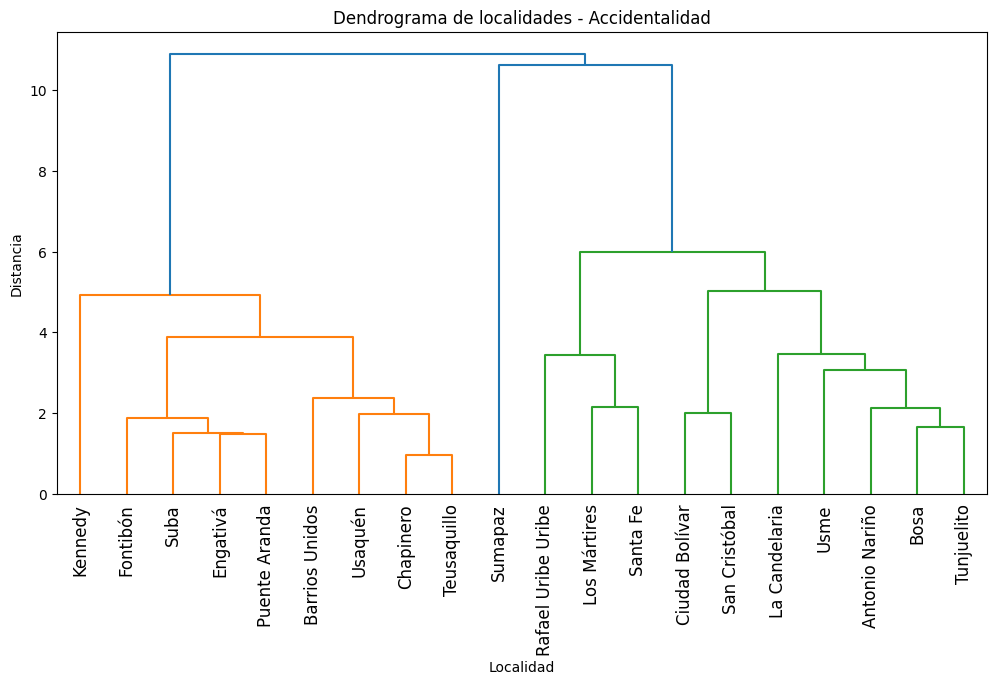

In [ ]:
linkage_matrix = sch.linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(linkage_matrix, labels=localidades.tolist(), leaf_rotation=90)
plt.title('Dendrograma de localidades - Accidentalidad')
plt.xlabel('Localidad')
plt.ylabel('Distancia')
plt.show()

Ahora se procede a realizar la asiganción de Clusteres, inicialmente en 3 grupos, esto se indica con ***t=3***, y con el parametro ***criterion='maxclust'***, se garantiza que la división del árbol genera esactamente los 3 grupos.

Luego, se agrega el resultado en una nueva columna llamada CLUSTER al dataframe y se visualiza el resultados de estas dos columnas:

In [ ]:
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
df_localidad['CLUSTER'] = clusters
df_localidad[['LOCALIDAD', 'TOTAL_ACCIDENTES', 'TOTAL_ACCIDENTES_GRAVES','%PORCENTAJE_GRAVES', 'CLUSTER']]

,LOCALIDAD,TOTAL_ACCIDENTES,TOTAL_ACCIDENTES_GRAVES,%PORCENTAJE_GRAVES,CLUSTER
0,Antonio Nariño,3974,1811,45.571213,2
1,Barrios Unidos,10351,2833,27.369336,1
2,Bosa,9634,4497,46.678431,2
3,Chapinero,11343,2642,23.291898,1
4,Ciudad Bolívar,7884,3821,48.465246,2
5,Engativá,19482,6304,32.358074,1
6,Fontibón,15362,4023,26.187996,1
7,Kennedy,22011,9323,42.356095,1
8,La Candelaria,1002,339,33.832335,2
9,Los Mártires,6594,2434,36.912345,2


Realizando un análisis de los porcentajes de accidentalidad graves, se puede observar que las localidades asignadas a los clusters 2 y 3 son las que presentan mayor indicice de accidentalidad grave, a comparación de las localidades asignadas al cluster 1.  Sin embargo es clave no exagerar la percepción, dado que si se analizan más datos como la cantidad total de accidentes se puede observar que existen localidades con muy pocos accidentes, pero que al tener un resultado grave, alteran la lectura de los datos.

Por lo tanto, se podría decir que:

*   **Cluster 1** => Son localidades más "seguras" en cuanto a gravedad relativa.
*   **Cluster 2** => Son localidades "más riesgosas" en términos de accidentes graves.
*   **Cluster 3** => Outlier o localidad con características especiales.

Para realizar el análisis de manera grafica, se procede a pintar un mapa de calor, en conjunto con el dentograma.

Se puede observar como las localidades con mayor semejanza se van agrupando y los colores tienden de azul a rojo según sea de menor a más alto el valor del porcentaje de accidentalidad.

En este caso, el outlier, que es la localidad de Sumapaz, presenta el mayor porcentaje de accidentes graves con un 71%, que corresponde a la clase de Volvamiento:

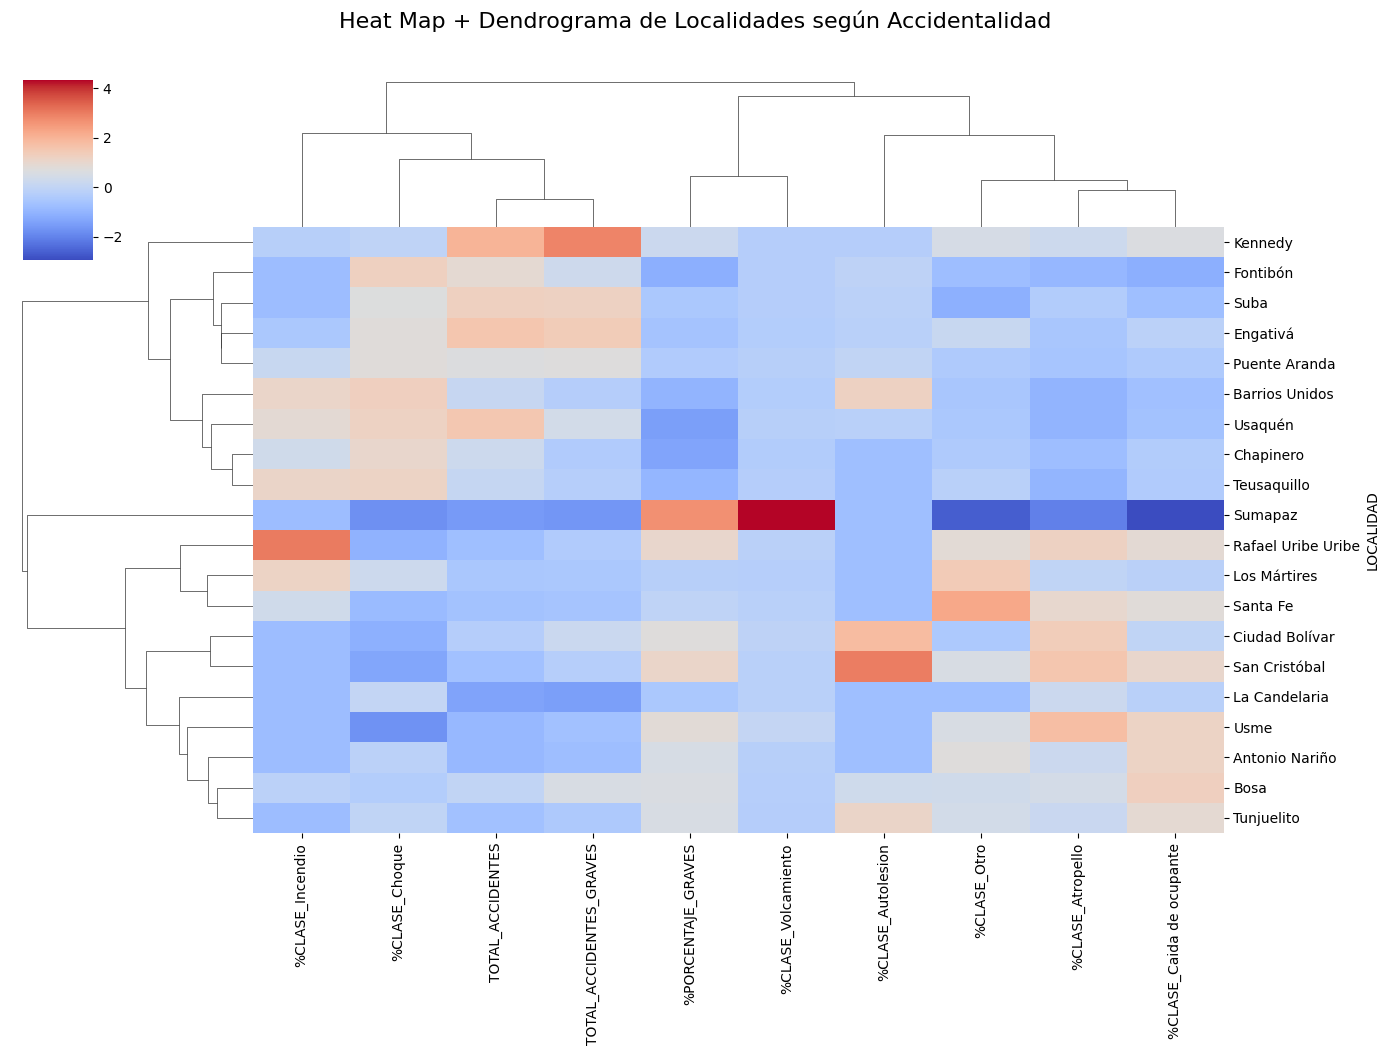

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

X_scaled_df = pd.DataFrame(X_scaled, index=localidades, columns=X.columns)

sns.clustermap(X_scaled_df,
               method='ward',
               metric='euclidean',
               cmap='coolwarm',
               figsize=(14, 10),
               standard_scale=None)
plt.suptitle('Heat Map + Dendrograma de Localidades según Accidentalidad', y=1.05, fontsize=16)
plt.show()